CUSTOMER LIFECYCLE


Recency (R): Days since last purchase.
Lower values = more engaged customers.

Tenure Days (T): Total days as a customer.
Higher values = longer relationship.
Combining these reveals customer lifecycle patterns:

New customers (Low T) with high recency (High R) → At risk of churning early.

Loyal customers (High T) with low recency (Low R) → Highly valuable.

Long-tenured but inactive (High T + High R) → Need re-engagement.

In [8]:
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import unique
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import os

df = pd.read_csv('featured_customer_segmentation.csv',dtype={'Lifecycle_Group': str})
# Calculate key ratios
df['Engagement_Ratio'] = df['Tenure_Days'] / (df['Recency'] + 1e-6)  # Avoid division by zero
df['Activity_Index'] = (1 / df['Recency']) * df['Tenure_Days']  # Weighted activity

# Binning for RFM-style segments
df['Recency_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1])  # Lower recency = higher score
df['Tenure_Score'] = pd.qcut(df['Tenure_Days'], q=5, labels=[1, 2, 3, 4, 5])  # Higher tenure = higher score
df['Lifecycle_Group'] = df['Recency_Score'].astype(str) + '-' + df['Tenure_Score'].astype(str)



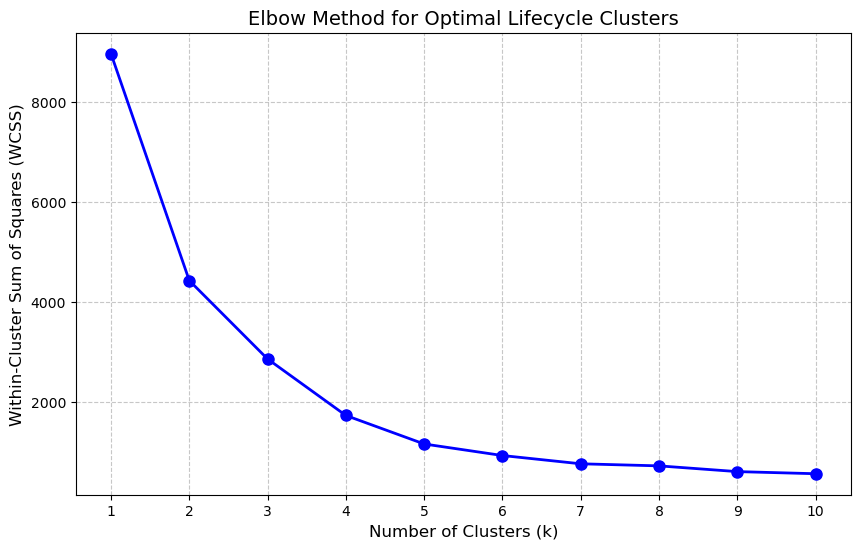

In [9]:


# 1. Calculate key ratios with safeguards
df['Engagement_Ratio'] = np.where(
    df['Recency'] == 0,
    df['Tenure_Days'] * 1000,  # Custom high value for Recency=0
    df['Tenure_Days'] / df['Recency']
)

df['Activity_Index'] = np.where(
    df['Recency'] == 0,
    df['Tenure_Days'] * 1000,  # Custom high value for Recency=0
    df['Tenure_Days'] / df['Recency']
)

# 2. Cap extreme values (99.5th percentile)
for col in ['Engagement_Ratio', 'Activity_Index']:
    upper_cap = df[col].quantile(0.995)
    df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])

# 3. Binning with duplicate handling
try:
    df['Recency_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    df['Tenure_Score'] = pd.qcut(df['Tenure_Days'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
except ValueError:
    # Fallback to equal-width binning if quantile binning fails
    df['Recency_Score'] = pd.cut(df['Recency'], bins=5, labels=[5, 4, 3, 2, 1])
    df['Tenure_Score'] = pd.cut(df['Tenure_Days'], bins=5, labels=[1, 2, 3, 4, 5])

# 4. Handle any remaining NaN values
df['Recency_Score'] = df['Recency_Score'].fillna(df['Recency_Score'].mode()[0])
df['Tenure_Score'] = df['Tenure_Score'].fillna(df['Tenure_Score'].mode()[0])

# 5. Convert to integer types
df['Recency_Score'] = df['Recency_Score'].astype(int)
df['Tenure_Score'] = df['Tenure_Score'].astype(int)

# 6. Prepare features for clustering
X = df[['Engagement_Ratio', 'Activity_Index', 'Recency_Score', 'Tenure_Score']]

# 7. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Elbow Method to find optimal clusters
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', markersize=8, linewidth=2)
plt.title('Elbow Method for Optimal Lifecycle Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.show()

NUMBER OF CUSTOMERS IN EACH SEGMENT

From the above elbow method,we were able to get k=3 therefore 3 clusters. Below 
we are obtaining the number of customers in each cluster

In [10]:
# Fit K-Means with optimal clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df['Lifecycle_Group'] = cluster_labels  # Store cluster assignments

# Count customers per cluster
cluster_counts = df['Lifecycle_Group'].value_counts().sort_index()
print("\nCustomer Count per Cluster:")
print(cluster_counts)

# Percentage distribution
cluster_percent = cluster_counts / len(df) * 100
print("\nPercentage Distribution:")
print(cluster_percent.map('{:.1f}%'.format))


Customer Count per Cluster:
Lifecycle_Group
0    1173
1      28
2    1039
Name: count, dtype: int64

Percentage Distribution:
Lifecycle_Group
0    52.4%
1     1.2%
2    46.4%
Name: count, dtype: object


In [11]:

# Generate cluster profile
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': ['mean', 'median'],
    'Tenure_Days': ['mean', 'median'],
    'Engagement_Ratio': 'median',
    'Activity_Index': 'median',
    'ID': 'count'
}).reset_index()

# Calculate percentage of total customers
cluster_profile['%_of_Customers'] = (cluster_profile[('ID', 'count')] / len(df)) * 100

# Add business interpretation
cluster_profile['Lifecycle_Stage'] = cluster_profile.apply(
    lambda row: "Churned" if row[('Recency', 'mean')] > 90 
    else "At-Risk" if row[('Recency', 'mean')] > 60 
    else "Loyal" if row[('Tenure_Days', 'mean')] > 365 
    else "New", axis=1
)

# Format column names for readability
cluster_profile.columns = [
    'Cluster',
    'Avg_Recency', 'Median_Recency',
    'Avg_Tenure', 'Median_Tenure',
    'Med_Engagement',
    'Med_Activity',
    'Customer_Count',
    '%_of_Base',
    'Lifecycle_Stage'
]

# Print the cluster profiles with descriptions
print("\nCluster Profiles with Business Interpretation:")
print(cluster_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', '%_of_Base', 
                       'Avg_Recency', 'Avg_Tenure', 'Med_Engagement', 'Med_Activity']])

# For a prettier table format:
from tabulate import tabulate

# Format numeric values for display
formatted_profile = cluster_profile.copy()
formatted_profile['%_of_Base'] = formatted_profile['%_of_Base'].map('{:.2f}%'.format)
formatted_profile['Avg_Recency'] = formatted_profile['Avg_Recency'].map('{:.1f}'.format)
formatted_profile['Avg_Tenure'] = formatted_profile['Avg_Tenure'].map('{:.1f}'.format)
formatted_profile['Med_Engagement'] = formatted_profile['Med_Engagement'].map('{:.3f}'.format)
formatted_profile['Med_Activity'] = formatted_profile['Med_Activity'].map('{:.3f}'.format)

# Print formatted table
print("\nFormatted Cluster Profiles:")
print(tabulate(
    formatted_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', '%_of_Base',
                       'Avg_Recency', 'Avg_Tenure', 'Med_Engagement', 'Med_Activity']],
    headers=['Cluster', 'Lifecycle Stage', 'Customers', '% of Base', 
             'Avg Recency', 'Avg Tenure', 'Med Engagement', 'Med Activity'],
    tablefmt='pretty',
    showindex=False
))


Cluster Profiles with Business Interpretation:
   Cluster Lifecycle_Stage  Customer_Count  %_of_Base  Avg_Recency  \
0        0         At-Risk            1173  52.366071    60.663257   
1        1           Loyal              28   1.250000     0.000000   
2        2           Loyal            1039  46.383929    37.388835   

    Avg_Tenure  Med_Engagement  Med_Activity  
0  4531.011083    7.208197e+01  7.208197e+01  
1  4326.928571    4.301500e+06  4.301500e+06  
2  4240.225217    1.375312e+02  1.375312e+02  

Formatted Cluster Profiles:
+---------+-----------------+-----------+-----------+-------------+------------+----------------+--------------+
| Cluster | Lifecycle Stage | Customers | % of Base | Avg Recency | Avg Tenure | Med Engagement | Med Activity |
+---------+-----------------+-----------+-----------+-------------+------------+----------------+--------------+
|    0    |     At-Risk     |   1173    |  52.37%   |    60.7     |   4531.0   |     72.082     |    72.082    |
| 

From the above we saw that both cluster 1 and cluster 2 have similar life stages "Loyal".it’s okay for two cluster groups to have similar lifecycle stages, as seen in your data where Clusters 1 and 2 are both labeled "Loyal." This can happen when clusters share a common characteristic (e.g., loyalty) but differ in other metrics, such as engagement or activity levels.Cluster 1 (Loyal, 1.25% of base): This smaller group (28 customers) shows extremely high engagement and activity (median ~4.3M), with zero recency (very recent interactions) and a slightly shorter tenure (~4327 days).Cluster 2 (Loyal, 46.38% of base): This larger group (1039 customers) has moderate engagement and activity (median ~137.5), with a recency of ~37.4 days and a tenure of ~4240 days. These customers are loyal but less active than Cluster 1.

Cluster 0 (At-Risk, 52.37% of base): This largest group (1173 customers) has the highest recency (~60.7 days, indicating less recent interactions), longest tenure (~4531 days), and lower engagement/activity (median ~72.1). These customers are at risk of churning, likely inactive or disengaged long-term customers.

In [12]:

# Load data
df = pd.read_csv('lifecycle.csv', dtype={'Lifecycle_Group': str})

# Group and aggregate cluster profile by Lifecycle_Group
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': 'mean',
    'Tenure_Days': 'mean',  # Added to include Tenure_Days
    'ID': 'count'
}).reset_index()

# Add percentage of customers
cluster_profile['%_of_Customers'] = (cluster_profile['ID'] / len(df)) * 100

# Business logic for lifecycle stages
cluster_profile['Lifecycle_Stage'] = cluster_profile.apply(
    lambda row: (
        "At-Risk" if row['Recency'] > 60 
        else "Loyal" if row['Tenure_Days'] > 365 
        else "Loyal"
    ), axis=1
)

# Rename columns for clarity
cluster_profile.columns = [
    'Cluster',
    'Avg_Recency',
    'Avg_Tenure',  # Added to reflect Tenure_Days
    'Customer_Count',
    '%_of_Base',
    'Lifecycle_Stage'
]

# Group by Lifecycle_Stage and aggregate Recency and Customer_Count
grouped_profile = cluster_profile.groupby('Lifecycle_Stage').agg({
    'Avg_Recency': 'mean',
    'Customer_Count': 'sum',
    '%_of_Base': 'sum'
}).reset_index()

# Print grouped profile summary
print("\nGrouped Cluster Profiles by Lifecycle Stage:")
print(grouped_profile[['Lifecycle_Stage', 'Customer_Count', 'Avg_Recency', '%_of_Base']])

# Optional: Print individual cluster details
print("\nIndividual Cluster Profiles:")
print(cluster_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', 'Avg_Recency', 'Avg_Tenure', '%_of_Base']])


Grouped Cluster Profiles by Lifecycle Stage:
  Lifecycle_Stage  Customer_Count  Avg_Recency  %_of_Base
0         At-Risk             884    79.355755  39.464286
1           Loyal            1356    29.397505  60.535714

Individual Cluster Profiles:
   Cluster Lifecycle_Stage  Customer_Count  Avg_Recency   Avg_Tenure  \
0      1-1         At-Risk              92    89.500000  4120.282609   
1      1-2         At-Risk              91    88.428571  4257.505495   
2      1-3         At-Risk              83    89.939759  4396.313253   
3      1-4         At-Risk              81    87.962963  4532.160494   
4      1-5         At-Risk             100    90.000000  4677.320000   
5      2-1         At-Risk              76    69.894737  4112.513158   
6      2-2         At-Risk              74    70.310811  4254.000000   
7      2-3         At-Risk             103    69.776699  4393.029126   
8      2-4         At-Risk             101    69.069307  4532.178218   
9      2-5         At-Risk    


Grouped Cluster Profiles by Lifecycle Stage:
  Lifecycle_Stage  Customer_Count  Avg_Recency  Med_Engagement  %_of_Base
0         At-Risk             884    79.355755       56.178473  39.464286
1           Loyal            1356    29.397505      241.010081  60.535714

Individual Cluster Profiles:
   Cluster Lifecycle_Stage  Customer_Count  Avg_Recency  Med_Engagement  \
0      1-1         At-Risk              92    89.500000       46.439670   
1      1-2         At-Risk              91    88.428571       48.528735   
2      1-3         At-Risk              83    89.939759       48.510869   
3      1-4         At-Risk              81    87.962963       52.011363   
4      1-5         At-Risk             100    90.000000       51.639613   
5      2-1         At-Risk              76    69.894737       58.495774   
6      2-2         At-Risk              74    70.310811       60.119717   
7      2-3         At-Risk             103    69.776699       62.154929   
8      2-4         At-Risk 

<Figure size 1500x1000 with 0 Axes>

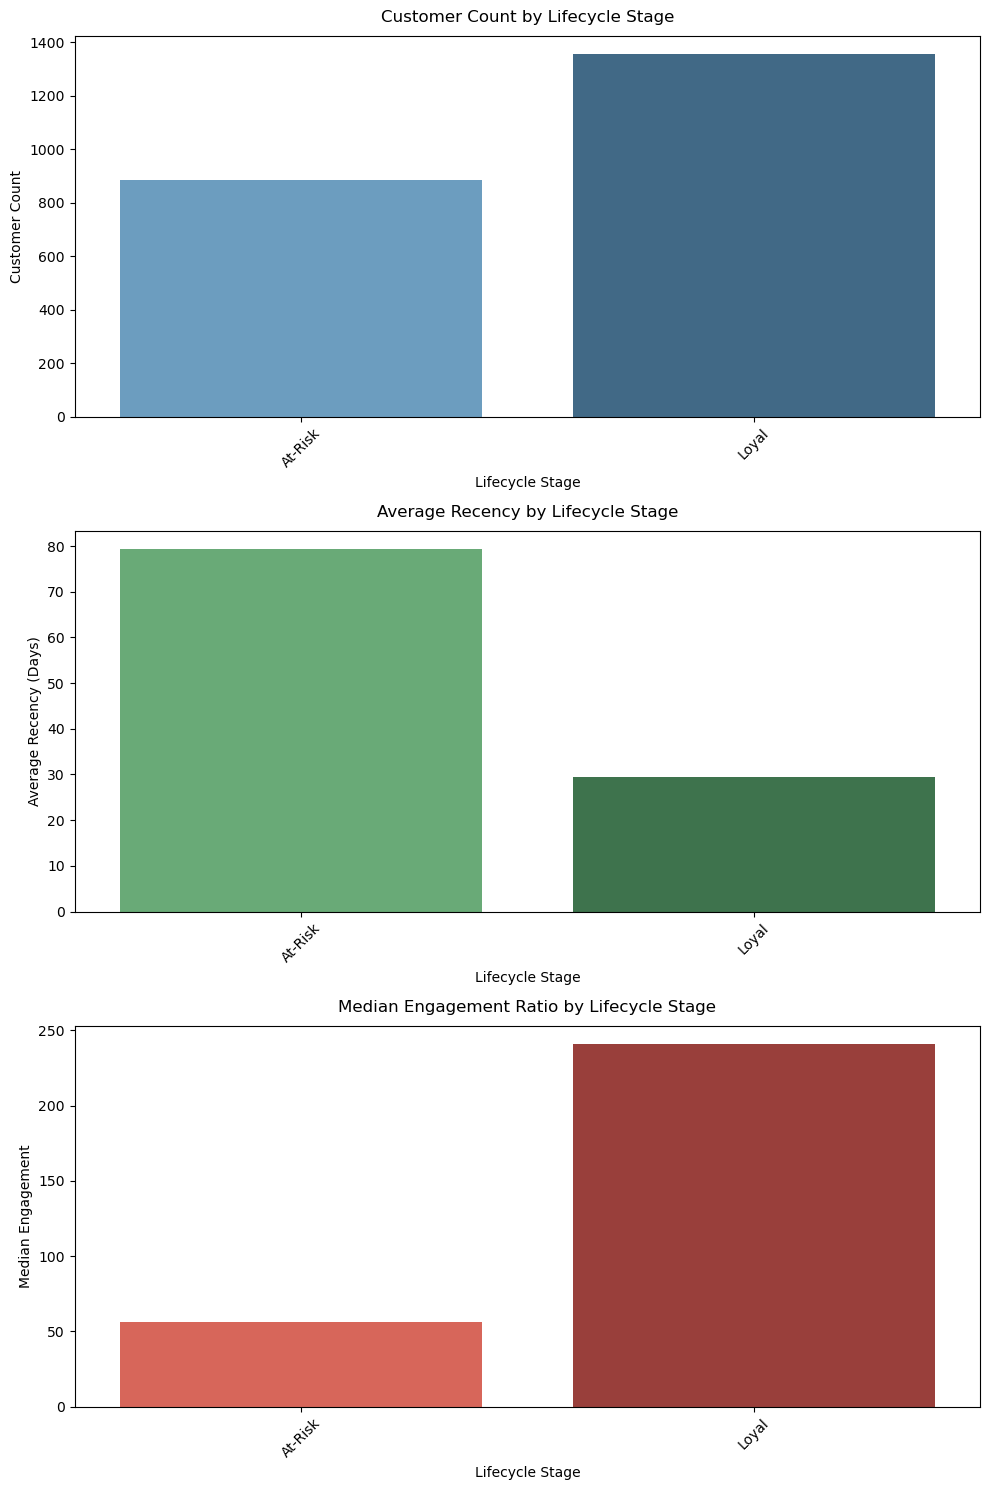

In [13]:


# Load data
df = pd.read_csv('lifecycle.csv', dtype={'Lifecycle_Group': str})

# Group and aggregate cluster profile by Lifecycle_Group
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': 'mean',
    'Tenure_Days': 'mean',
    'Engagement_Ratio': 'median',  # Added for Med_Engagement
    'ID': 'count'
}).reset_index()

# Add percentage of customers
cluster_profile['%_of_Customers'] = (cluster_profile['ID'] / len(df)) * 100

# Business logic for lifecycle stages
cluster_profile['Lifecycle_Stage'] = cluster_profile.apply(
    lambda row: (
        "At-Risk" if row['Recency'] > 60 
        else "Loyal" if row['Tenure_Days'] > 365 
        else "Loyal"
    ), axis=1
)

# Rename columns for clarity
cluster_profile.columns = [
    'Cluster',
    'Avg_Recency',
    'Avg_Tenure',
    'Med_Engagement',  # Renamed from Engagement_Ratio median
    'Customer_Count',
    '%_of_Base',
    'Lifecycle_Stage'
]

# Group by Lifecycle_Stage and aggregate Recency, Customer_Count, and Med_Engagement
grouped_profile = cluster_profile.groupby('Lifecycle_Stage').agg({
    'Avg_Recency': 'mean',
    'Customer_Count': 'sum',
    'Med_Engagement': 'mean',  # Added for grouped engagement
    '%_of_Base': 'sum'
}).reset_index()

# Print grouped profile summary
print("\nGrouped Cluster Profiles by Lifecycle Stage:")
print(grouped_profile[['Lifecycle_Stage', 'Customer_Count', 'Avg_Recency', 'Med_Engagement', '%_of_Base']])

# Print individual cluster details
print("\nIndividual Cluster Profiles:")
print(cluster_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', 'Avg_Recency', 'Med_Engagement', 'Avg_Tenure', '%_of_Base']])

# Plotting
plt.figure(figsize=(15, 10))

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Bar plot for Customer Count by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Customer_Count', hue='Lifecycle_Stage', data=grouped_profile, ax=axes[0], palette='Blues_d', legend=False)
axes[0].set_title('Customer Count by Lifecycle Stage', fontsize=12, pad=10)
axes[0].set_xlabel('Lifecycle Stage', fontsize=10)
axes[0].set_ylabel('Customer Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for Average Recency by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Avg_Recency', hue='Lifecycle_Stage', data=grouped_profile, ax=axes[1], palette='Greens_d', legend=False)
axes[1].set_title('Average Recency by Lifecycle Stage', fontsize=12, pad=10)
axes[1].set_xlabel('Lifecycle Stage', fontsize=10)
axes[1].set_ylabel('Average Recency (Days)', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Bar plot for Median Engagement by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Med_Engagement', hue='Lifecycle_Stage', data=grouped_profile, ax=axes[2], palette='Reds_d', legend=False)
axes[2].set_title('Median Engagement Ratio by Lifecycle Stage', fontsize=12, pad=10)
axes[2].set_xlabel('Lifecycle Stage', fontsize=10)
axes[2].set_ylabel('Median Engagement', fontsize=10)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

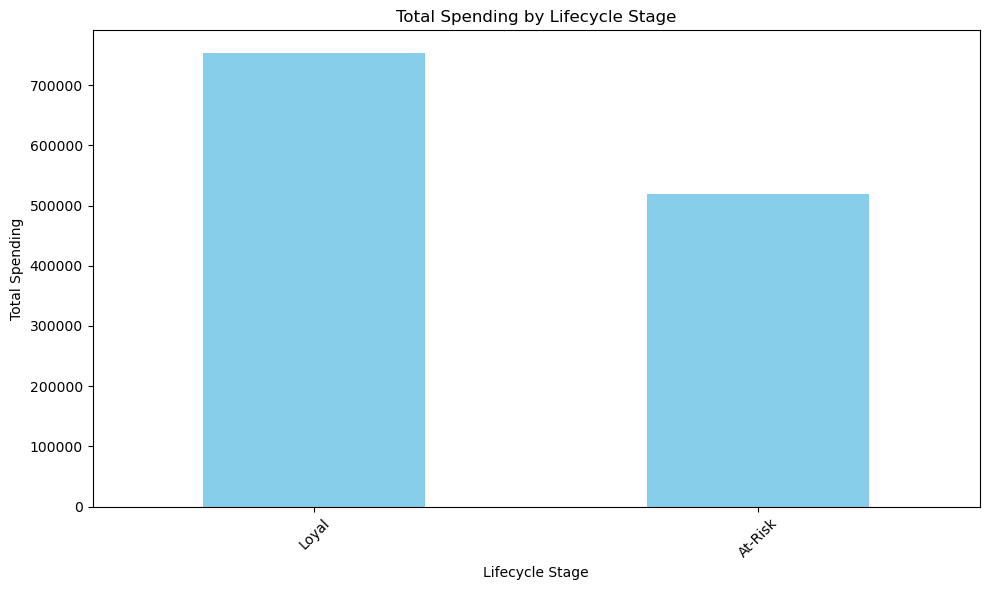

In [14]:
# Create a dictionary from cluster_profile
cluster_to_stage = dict(zip(cluster_profile['Cluster'], cluster_profile['Lifecycle_Stage']))

# Map lifecycle stage back to the main df
df['Lifecycle_Stage'] = df['Lifecycle_Group'].map(cluster_to_stage)
spending_by_stage = df.groupby('Lifecycle_Stage')['Total_Spending'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
spending_by_stage.plot(kind='bar', color='skyblue')
plt.title('Total Spending by Lifecycle Stage')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
df = pd.read_csv('lifecycle.csv', dtype={'Lifecycle_Group': str})

# Define features and target
features = ['Engagement_Ratio', 'Activity_Index', 'Total_Spending']  # Excluded Recency, Tenure_Days to avoid leakage
target = 'Lifecycle_Stage'

# Check for infinite or NaN values in features
print("Checking for NaN values in features:")
print(df[features].isna().sum())
print("Infinite values in features:")
print(np.isinf(df[features]).sum())

# Handle infinite and NaN values
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
# Cap Activity_Index at 99th percentile to preserve variability
activity_cap = df['Activity_Index'].replace([np.inf, -np.inf], np.nan).quantile(0.99)
df['Activity_Index'] = df['Activity_Index'].clip(upper=activity_cap)
# Fill NaN with median for remaining features
df[features] = df[features].fillna(df[features].median())

# Cap extremely large values to prevent float32 overflow
max_float32 = 3.4e38
df[features] = df[features].clip(upper=max_float32, lower=-max_float32)

# Assign Lifecycle_Stage to each row (At-Risk and Loyal)
df['Lifecycle_Stage'] = df.apply(
    lambda row: (
        "At-Risk" if row['Recency'] > 60 
        else "Loyal" if row['Tenure_Days'] > 365 
        else "Loyal"
    ), axis=1
)

# Prepare features and target
X = df[features]
y = df[target]

# Scale features to improve efficiency and model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Verify X_train has no infinite or NaN values
if np.any(np.isinf(X_train)) or np.any(np.isnan(X_train)):
    raise ValueError("X_train contains infinite or NaN values after preprocessing!")

# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
model = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_
print("\nBest Hyperparameters:", search.best_params_)

# Cross-validation to assess generalization
cv_scores = cross_val_score(best_model, X_scaled, y_encoded, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))

# Calculate and print test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Set Accuracy: {:.2f}".format(test_accuracy))

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nModel Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Optional: Visualize feature importance
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for RandomForestClassifier')
plt.tight_layout()
plt.show()

Checking for NaN values in features:
Engagement_Ratio    0
Activity_Index      0
Total_Spending      0
dtype: int64
Infinite values in features:
Engagement_Ratio    0
Activity_Index      0
Total_Spending      0
dtype: int64

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Cross-Validation Accuracy: 0.97 ± 0.01


NameError: name 'y_pred' is not defined

In [ ]:
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': 'mean',
    'Engagement_Ratio': 'median',
    'Activity_Index': 'median',
    'Tenure_Days': 'mean',
    'Lifecycle_Stage': 'first',
    'ID': 'count'
}).reset_index()
print(cluster_profile[['Lifecycle_Group', 'Lifecycle_Stage', 'ID', 'Recency', 'Engagement_Ratio', 'Activity_Index', 'Tenure_Days']])

   Lifecycle_Group Lifecycle_Stage   ID    Recency  Engagement_Ratio  \
0              1-1         At-Risk   92  89.500000         46.439670   
1              1-2         At-Risk   91  88.428571         48.528735   
2              1-3         At-Risk   83  89.939759         48.510869   
3              1-4         At-Risk   81  87.962963         52.011363   
4              1-5         At-Risk  100  90.000000         51.639613   
5              2-1         At-Risk   76  69.894737         58.495774   
6              2-2         At-Risk   74  70.310811         60.119717   
7              2-3         At-Risk  103  69.776699         62.154929   
8              2-4         At-Risk  101  69.069307         65.420289   
9              2-5         At-Risk   83  68.674699         68.463767   
10             3-1           Loyal   91  49.747253         80.176469   
11             3-2           Loyal   86  49.581395         86.419998   
12             3-3           Loyal  100  50.680000         85.99